# TP5 (1) - Dialogue Systems

Group members:
- Thanh Gia Hieu KHUONG
- Ragi BHATT
- Benedictus Kent RACHMAT 

In [3]:
!pip install -q datasets pandas matplotlib scikit-learn transformers rouge evaluate tqdm

In [3]:
!wget https://gitlab.dsi.universite-paris-saclay.fr/thomas.gerald/textminingandchatbot/-/raw/main/tp/TP-1/tp-content.zip?ref_type=heads&inline=false
!unzip tp-content.zip

unzip:  cannot find or open 1-IntentAndSlot.zip, 1-IntentAndSlot.zip.zip or 1-IntentAndSlot.zip.ZIP.


# JOINT INTENT DETECTION AND SLOT FILLING

In this application we will develop different NLU systems on the ATIS, SNIPS and MEDIA datasets. The ATIS corpus a flight reservation dialogue dataset, the data are provided in the BIO format. The SNIPS corpus regroup different intent from reservation to playlist management. The MEDIA dataset is a french corpus on hotel booking however it is noisy (due to audio transcription)
Two different approaches will be considered in the current application for intent detection :
* Classifier on BOW like features
* RNN with word embedding
For slot filling the objectives is to implement an RNN (considering same model for intent detection and slot filling)


In [4]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from collections import Counter
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence

##  Part 1 : The dataset

Explore the different dataset, how they are annotated and what are their specificities

In [108]:
atis_data_path = 'data/NLU/atis-corpus/atis.{}.csv'
snips_data_path = 'data/NLU/snips-corpus/snips.{}.csv'
media_data_path = 'data/NLU/media-corpus/media.{}.csv'

current_data_path = snips_data_path

In [109]:
training_set = pd.read_csv(current_data_path.format('train'), index_col='id')
validation_set = pd.read_csv(current_data_path.format('dev'), index_col='id')
testing_set = pd.read_csv(current_data_path.format('test'), index_col='id')

## 1.1 Plotting the data
Plot both intent and slots for the different corpus

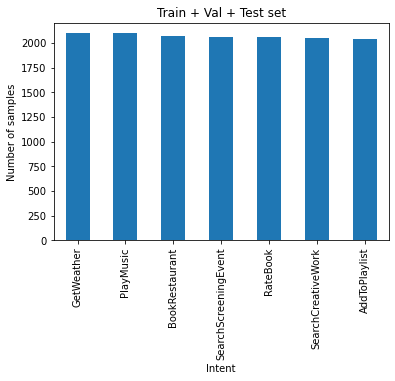

In [110]:
# training_set.value_counts('intent').plot.bar()
all_data = pd.concat([training_set, validation_set, testing_set])
intent_counts = all_data.value_counts('intent')

if not intent_counts.empty:
    intent_counts.plot.bar()
    plt.title('Train + Val + Test set')
    plt.xlabel('Intent')
    plt.ylabel('Number of samples')
    plt.show()
else:
    print("No data available to plot.")

In [111]:
def analyze_dataset(data):
    if 'intent' in data.columns:
        unique_intents = data['intent'].nunique()
        intent_distribution = data['intent'].value_counts()
    else:
        unique_intents = 0
        intent_distribution = "No intent column found."

    all_slots = data['slots'].str.split().explode()
    unique_slots = all_slots.nunique()
    slot_distribution = all_slots.value_counts()

    print(f"Number of unique intents: {unique_intents}")
    print(f"Number of unique slots: {unique_slots}")
    if unique_intents > 0:
        print(f"Intent distribution:\n{intent_distribution}\n")
    print(f"Slot distribution:\n{slot_distribution}\n")

    return unique_intents, unique_slots, intent_distribution, slot_distribution

analyse_data = analyze_dataset(all_data)


Number of unique intents: 7
Number of unique slots: 72
Intent distribution:
GetWeather              2100
PlayMusic               2100
BookRestaurant          2073
SearchScreeningEvent    2059
RateBook                2056
SearchCreativeWork      2053
AddToPlaylist           2042
Name: intent, dtype: int64

Slot distribution:
O                               64291
I-object_name                    8223
I-playlist                       3610
B-object_type                    3340
B-object_name                    3086
                                ...  
I-cuisine                          33
I-facility                         14
I-object_select                     5
I-object_part_of_series_type        3
I-playlist_owner                    1
Name: slots, Length: 72, dtype: int64



## 1.2 Datasets characteristics [NOTE should we remove the O] ?

### ATIS Dataset
* **How many possible intents for the dataset?**
  - Number of Intents: 17

* **How many slots?**
  - Number of Slots: 101

* **How are they distributed? What are the most frequent values?**
  - Most Frequent Intent: `atis_flight`
  - Most Frequent Slot: `O`
  - Intent Distribution: The intents are varied, with `atis_flight` being the most frequent.
  - Slot Distribution: Most slots are 'O' (Outside), followed by location-based slots like `B-fromloc.city_name`.

### Media Dataset
* **How many possible intents for the dataset?**
  - Number of Intents: 0 (Intents data appears to be missing or not properly labeled)

* **How many slots?**
  - Number of Slots: 151

* **How are they distributed? What are the most frequent values?**
  - Most Frequent Slot: `O`
  - Slot Distribution: Majority are 'O' (Outside), followed by command-based slots like `reponse-B`.

### SNIPS Dataset
* **How many possible intents for the dataset?**
  - Number of Intents: 7

* **How many slots?**
  - Number of Slots: 72

* **How are they distributed? What are the most frequent values?**
  - Most Frequent Intent: `GetWeather` and `PlayMusic`
  - Most Frequent Slot: `O`
  - Intent Distribution: Evenly distributed among intents.
  - Slot Distribution: Primarily 'O' (Outside), with frequent entity names and playlist slots like `I-object_name`.


## PART 2 Learning BOW classifiers 
From the code below propose different classifier for intent (for both snips and atis)

In [47]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer 

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline

LIST_MODEL = [LogisticRegression, MultinomialNB, SVC]

for model in LIST_MODEL:
    text_clf = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', model()),
    ])
    text_clf.fit(training_set['tokens'], training_set['intent'])
    predicted = text_clf.predict(validation_set['tokens'])
    print(f"Model {model.__name__} : {np.mean(predicted == validation_set['intent'])}")

Model LogisticRegression : 0.9842857142857143
Model MultinomialNB : 0.9771428571428571
Model SVC : 0.9857142857142858


Fill the following table replacing value and named classifiers

| Dataset   | Acc Logistic Regression | Acc MultinomialNB |Acc SVM |
| -------- | ------- |------- |------- |
| ATIS  | 0.92    |0.84    | 0.95 |
| SNIPS | 0.984     |0.97    |  0.985 |



## PART 3 Learning RNN

### 1.1 Prepare the data and tools
The objective of the following question is to prepare the data to run with the model.
In this example we will create different component :
* intent_encoder (from textual intent return its id)
* slot_encoder (from list or string separated by space of textual slot return id)
* tokenizer (from list or string separated by space of textual slot return id)
* BIONLUDataset a dataset like class returning all the information necessary for training
* Dataloader that allow to create batch of the data (usefull for training)

In [115]:
'''This class encode labels or list of labels given an index
'''
class LabelEncoder:
    def __init__(self, index):
        self.index = index
        self.iindex = {v: k for k, v in index.items()}
    
    def get_id_list_from_text(self, text):
        return [self.index[w] for w in text.split()]

    def get_label_list_from_id(self, label_ids):
         return [self.iindex[lid] for lid in label_ids]

    def to_label_list(self, text):
        return text.split()

    # method call can be called by instance_object(parameters)
    def __call__(self, text):
        return self.get_id_list_from_text(text)

In [116]:
def create_label_index(labels):
    """Create an index (dictionary) for labels."""
    label_to_id = {}
    for label in labels:
        if label not in label_to_id:
            label_to_id[label] = len(label_to_id)
    return label_to_id

intents = training_set['intent'].unique()
slots = set(slot for row in training_set['slots'] for slot in row.split())

intent_index = create_label_index(intents)
slot_index = create_label_index(slots)

In [117]:
intent_encoder = LabelEncoder(intent_index)
slot_encoder = LabelEncoder(slot_index)

### Create a tokenizer
Fill the Tokenizer class to transform text tokens into token ids. From a list of words (or string of wards separated by space) return a sequence of ids (each word as a unique id).

In [121]:
'''This class should tokenize a text or a list of tokens.
'''  
class Tokenizer:

    def __init__(self, list_text, unk_token="UNKNOW_WORD"):
        # create a vocbulary index 
        self.vocab = np.unique([word for text in list_text for word in text.split()])
        self.vocab_index = {w: i for i, w in enumerate(self.vocab)}
        self.vocab_index[unk_token] = len(self.vocab_index)
        self.unk_token = unk_token
        
    def __call__(self, text):
        # Tokenize the text or word sequence
        if isinstance(text, list):
            return [self.vocab_index.get(word, self.vocab_index[self.unk_token]) for word in text]
        else:
            return [self.vocab_index.get(word, self.vocab_index[self.unk_token]) for word in text.split()]

    def decode(self, ids):
        # Decode the text ids to a sentence
        index_to_vocab = {i: w for w, i in self.vocab_index.items()}
        return ' '.join(index_to_vocab.get(id, self.unk_token) for id in ids)
        
    def __len__(self):
        # get the vocabulary lenght
        return len(self.vocab)

In [122]:
tokenizer = Tokenizer(
    list(training_set['tokens']) + 
    list(validation_set['tokens']) + 
    list(testing_set['tokens'])
)

### Create the dataset

The dataset class below must return all needed informations for prediction, here the **text** (initial utterance), the intent label name (**i_label**), the list of slots names for the sequence (**s_label**), the text transformed into list of tokens(**x**), the id of the coresponding intent (**i_id**), the list of ids of the coresponding slots names (**s_ids**) and, the len of the squence (the number of words) (**seq_len**).

In [124]:
class BIONLUDataset():
    def __init__(self, data, intent_index, slot_index, text_transform):
        self.data = data
        self.i_enc = LabelEncoder(intent_index)
        self.s_enc = LabelEncoder(slot_index)
        self.t_transform = text_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        text = row['tokens']
        i_label = row['intent']
        s_label = row['slots']
        
        x = self.t_transform(text)
        i_id = self.i_enc(i_label)[0]
        s_ids = self.s_enc(s_label)
        
        assert(len(s_ids) == len(x))
        
        return {'text': text, 'i_label': i_label, 's_labels': s_label,
                'x': x, 'i_id': i_id, 's_ids': s_ids, "seq_len": len(x)}

**Create the different set :** below we create the different, for each we give the set data, the intent_index (to allow to transform intent label to its corresponding id), the slot_index (to transform slot_type to id) and the tokenizer (which simply split text by words and return the sequence of tokens/words ids).

In [125]:
# create a simple tokenizer on all words of the corpus 

train = BIONLUDataset(training_set, intent_index, slot_index, tokenizer)
val = BIONLUDataset(validation_set, intent_index, slot_index, tokenizer)
test = BIONLUDataset(testing_set, intent_index, slot_index, tokenizer)

**The collate function:** to load the data as batch we need to return tensors to the pytorch model we will see later. Here we need as input of the model the intents ids, the slots_ids (which is a sequence of the size of text), the input given to the model (named x).

In [59]:
def rnn_collator(batch):
    i_ids = []
    seq_len = []
    s_ids = []
    x = []
    mask = []
    for item in batch:
        i_ids.append(item['i_id'])
        s_ids.append(torch.LongTensor(item['s_ids']))
        seq_len.append(item['seq_len'])
        x.append(torch.Tensor(item['x']))
        mask.append(torch.ones(item['seq_len']))

    return{
        "i_ids" : torch.LongTensor(i_ids),
        "s_ids" : pad_sequence(s_ids, padding_value=-1, batch_first=True),
        "x" : pad_sequence(x, padding_value=0, batch_first=True),
        "seq_len" : torch.LongTensor(seq_len), 
        "mask": pad_sequence(mask, padding_value=0, batch_first=True)
    }

In [61]:
from torch.utils.data import DataLoader

training_dl = DataLoader(train , batch_size=16,
                         collate_fn=rnn_collator,
                         shuffle=True
                        )
validation_dl = DataLoader(val, batch_size=16,
                         collate_fn=rnn_collator
                        )

### 1.2 Create the model

In [76]:
from library.model import IntentSlotRNN

class LSTMForClassification(nn.Module):
    def __init__(self, vocabulary_size, embedding_size=300, hidden_size=100, n_slot=101, n_intent=17):
        super().__init__()
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.rnn = IntentSlotRNN(embedding_size, hidden_size, n_intent, n_slot)
    
    def forward(self, input_ids, seq_len, mask=None):
        if mask is None:
            mask = input_ids.new_ones(input_ids.shape).float()
        input_ids = input_ids.long()  # Convert input_ids to LongTensor
        emb = self.embedding(input_ids)
        return self.rnn(emb, seq_len, mask)

### 1.3 Training the model

In [64]:
from tqdm.notebook import trange
from torch import optim
from torch import nn

class Trainer():
    def __init__(self, model):
        self.model = model 
        self.optimizer = None

    def before_training_loop(self, learning_rate = 1e-3):
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.criterion = nn.CrossEntropyLoss(ignore_index=-1)

    def validation_step(self, data):
        y_pred = self.model(data["x"], data["seq_len"], data['mask'])    
        y_intent_truth = data["i_ids"]
        y_slot_truth = data["s_ids"]
        #print(y_slot_truth)
        y_intent_pred = y_pred["y_intent"]
        #print(y_pred["y_slot"].shape)
        y_slot_pred = y_pred["y_slot"].view(y_slot_truth.shape[0] * y_slot_truth.shape[-1], -1)
        minus_one = (data["mask"] - 1)
        y_slot_pred *= data["mask"].view(y_slot_truth.shape[0] * y_slot_truth.shape[-1], -1)
        # y_slot_pred += minus_one.view(y_slot_truth.shape[0] * y_slot_truth.shape[-1], -1)
        return {
            'mask' : minus_one.view(y_slot_truth.shape[0] * y_slot_truth.shape[-1], -1),
            'len' : len(data['x']),
            'intent_pred': y_intent_pred,
            'intent_truth': y_intent_truth,
            'slot_pred': y_slot_pred,
            'slot_truth': y_slot_truth
        }

    def training_step(self, data):
        y_pred = self.model(data["x"], data["seq_len"], data['mask'])    
        y_intent_truth = data["i_ids"]
        y_slot_truth = data["s_ids"]
        loss_intent = self.criterion(y_pred["y_intent"], y_intent_truth)

        y_slot_pred = y_pred["y_slot"].view(y_slot_truth.shape[0] * y_slot_truth.shape[-1], -1)
        y_slot_pred *= data["mask"].view(y_slot_truth.shape[0] * y_slot_truth.shape[-1], -1)
            
        loss_slot = self.criterion(y_slot_pred, y_slot_truth.view(-1))
        (loss_slot + loss_intent).backward()
        return loss_slot.item() + loss_intent.item()

    def on_validation_end(self, resp):
        i_truth = [d["intent_truth"] for d in resp]
        s_truth = [d["slot_truth"].flatten() for d in resp]
        
        i_pred = [d["intent_pred"] for d in resp]
        s_pred =  [d["slot_pred"].argmax(-1).flatten() + d['mask'].max(-1).values.flatten() for d in resp]
        size = sum([d['len'] for d in resp ])
        print('Intent validation accuracy : %s'%(((torch.cat(i_pred).argmax(-1) == torch.cat(i_truth)).sum()/size).item(),))
        print('Slot validation accuracy : %s'%(((torch.cat(s_pred) == torch.cat(s_truth)).sum()/len(torch.cat(s_truth))).item(),))
        print("-------------------------------")
    
    def validation(self, validation_dl):
        with torch.no_grad():
            resp = []
            for data in validation_dl:
                resp.append(self.validation_step(data))
        self.on_validation_end(resp)

    def fit(self, 
            training_dl,
            validation_dl,
            learning_rate = 1e-3,
            validation_frequency = 128,
            max_iter = 10000,
        ):

        self.before_training_loop(learning_rate)
        
        iter_count = 0
        loss_buffer = []
        pbar = trange(max_iter)
        
        while(True):
            for data in training_dl:
                self.optimizer.zero_grad()
                loss_buffer += [self.training_step(data)]
                self.optimizer.step()

                if(iter_count  % validation_frequency == 0):
                    print("Loss at iteration %s is %s"%(iter_count, np.mean(loss_buffer)))
                    self.validation(validation_dl)

                iter_count += 1
                if(iter_count >= max_iter):
                    return
                pbar.update(1)

In [126]:
vocabulary_size = len(tokenizer)
model = LSTMForClassification(vocabulary_size)
trainer = Trainer(model)
trainer.fit(training_dl, validation_dl, validation_frequency=500)

### 1.4 Evaluate the model on the test set using accuracy
* Hint : see validation step

In [74]:
class NLU:
    def __init__(self, model, intent_encoder, slot_encoder, nlp):
        self.nlp = nlp
        self.model = model 
        self.intent_encoder = intent_encoder
        self.slot_encoder = slot_encoder
    
    def __call__(self, text):
        input_data = self.nlp(text)
        with torch.no_grad():
            y = self.model(torch.LongTensor([input_data]),  [len(input_data)])

        intent = self.intent_encoder.get_label_list_from_id(y['y_intent'].max(-1)[1].tolist())

        slots = self.slot_encoder.get_label_list_from_id(y['y_slot'].max(-1)[1].tolist()[0])
        return intent, list(zip(slots, text.split()))

In [ ]:
nlu = NLU(trainer.model, intent_encoder, slot_encoder, naive_tokenizer)
nlu("i'm looking for a good restauranta in chicago")

# what is naive_tokenizer?

In [ ]:
raise NotImplementedError

### 1.5 Change the model to use pretrained embeddings !
* You can use global pretrained embeddings for SNIPS and ATIS
* You can use pretrained last week course embeddings for MEDIA !!! 